<a href="https://colab.research.google.com/github/luck058/kaggle-gold-price-analysis/blob/model-1/model_1_kaggle_gold_price_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
!git clone https://github.com/luck058/kaggle-gold-price-analysis

%cd kaggle-gold-price-analysis

Cloning into 'kaggle-gold-price-analysis'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 78 (delta 38), reused 19 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (78/78), 1.32 MiB | 3.91 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/kaggle-gold-price-analysis


# Create X, y

In [94]:
asset = "sp500"

In [96]:
df = pd.read_csv('financial_regression_cleaned.csv')

# Only care about "asset"
original_cols = [f'{asset} open', f'{asset} high', f'{asset} low', f'{asset} close', f'{asset} volume']
df = df[original_cols].reset_index(drop=True)
df[f'{asset} high-low'] = df[f'{asset} high'] - df[f'{asset} low']
df[f'{asset} close-open'] = df[f'{asset} close'] - df[f'{asset} open']

display(df.head())
print(df.shape)

,sp500 open,sp500 high,sp500 low,sp500 close,sp500 volume,sp500 high-low,sp500 close-open,a
0,114.49,115.14,114.42,114.93,115646960.0,0.72,0.44,0.72
1,114.73,114.84,113.20,113.64,212252769.0,1.64,-1.09,1.64
2,113.62,115.13,113.59,115.06,138671890.0,1.54,1.44,1.54
3,114.28,114.45,112.98,113.89,216330645.0,1.47,-0.39,1.47
4,113.92,114.27,111.56,111.70,344747028.0,2.71,-2.22,2.71


(3719, 8)


In [97]:
df[f"{asset} close diff"] = df[f"{asset} close"].diff()

other_core_cols = [f'{asset} high-low', f'{asset} close-open', f'{asset} close diff']

display(df.head())
print(df.shape)

,sp500 open,sp500 high,sp500 low,sp500 close,sp500 volume,sp500 high-low,sp500 close-open,a,sp500 close diff
0,114.49,115.14,114.42,114.93,115646960.0,0.72,0.44,0.72,NaN
1,114.73,114.84,113.20,113.64,212252769.0,1.64,-1.09,1.64,-1.29
2,113.62,115.13,113.59,115.06,138671890.0,1.54,1.44,1.54,1.42
3,114.28,114.45,112.98,113.89,216330645.0,1.47,-0.39,1.47,-1.17
4,113.92,114.27,111.56,111.70,344747028.0,2.71,-2.22,2.71,-2.19


(3719, 9)


In [5]:
def create_lag(df, column, lookback):
    assert column in df.columns
    for lag in range(1, lookback):
        if np.log2(lag) % 1 == 0:
            df[f'{column}-{lag}'] = df[column].shift(lag)

In [6]:
create_lag(df, f'{asset} close', 20)
display(df.head())

,sp500 open,sp500 high,sp500 low,sp500 close,sp500 volume,sp500 high-low,sp500 close diff,sp500 close-1,sp500 close-2,sp500 close-4,sp500 close-8
0,114.49,115.14,114.42,114.93,115646960.0,0.72,NaN,NaN,NaN,NaN,NaN
1,114.73,114.84,113.20,113.64,212252769.0,1.64,-1.29,114.93,NaN,NaN,NaN
2,113.62,115.13,113.59,115.06,138671890.0,1.54,1.42,113.64,114.93,NaN,NaN
3,114.28,114.45,112.98,113.89,216330645.0,1.47,-1.17,115.06,113.64,NaN,NaN
4,113.92,114.27,111.56,111.70,344747028.0,2.71,-2.19,113.89,115.06,114.93,NaN


In [7]:
def get_max(df, column, lookback, name_append=None):
    assert column in df.columns
    df[f'{column}-max{name_append}'] = df[column].rolling(lookback).max()

In [8]:
def get_min(df, column, lookback, name_append=None):
    assert column in df.columns
    df[f'{column}-min{name_append}'] = df[column].rolling(lookback).min()

In [9]:
def get_min_max(df, column, lookback, name_append=None):
    assert column in df.columns
    get_max(df, column, lookback, name_append=name_append)
    get_min(df, column, lookback, name_append=name_append)

In [10]:
for column in original_cols + [f"{asset} close diff"]:
    get_min_max(df, column, 5, "-short")


In [11]:
for column in original_cols + [f"{asset} close diff"]:
    get_min_max(df, column, 20, "-long")


In [12]:
def get_mean(df, column, lookback, name_append=None):
    assert column in df.columns
    df[f'{column}-mean{name_append}'] = df[column].rolling(lookback).mean()

In [13]:
for column in original_cols + [f"{asset} close diff"]:
    get_min_max(df, column, 5, "-short")

In [14]:
for column in original_cols + [f"{asset} close diff"]:
    get_min_max(df, column, 20, "-long")

## Create y

In [15]:
y_col = f"{asset} close diff"
y_col = f"{asset} close"

df[y_col] = df[y_col].shift(-1)
df = df.dropna(axis=0).reset_index(drop=True)

display(df.head())

,sp500 open,sp500 high,sp500 low,sp500 close,sp500 volume,sp500 high-low,sp500 close diff,sp500 close-1,sp500 close-2,sp500 close-4,...,sp500 low-max-long,sp500 low-min-long,sp500 close-max-long,sp500 close-min-long,sp500 volume-max-long,sp500 volume-min-long,sp500 high-low-max-long,sp500 high-low-min-long,sp500 close diff-max-long,sp500 close diff-min-long
0,106.99,108.10,106.51,109.74,304335521.0,1.59,-0.09,108.13,107.01,105.89,...,113.59,104.58,115.06,105.89,493483874.0,138671890.0,2.71,0.97,1.67,-3.39
1,108.86,109.85,107.82,110.26,159025359.0,2.03,1.70,108.04,108.13,107.22,...,113.59,104.58,115.06,105.89,493483874.0,138671890.0,2.71,0.97,1.70,-3.39
2,110.27,110.41,109.74,110.91,168609976.0,0.67,0.52,109.74,108.04,107.01,...,112.98,104.58,113.89,105.89,493483874.0,159025359.0,2.71,0.67,1.70,-3.39
3,110.08,111.14,110.04,111.14,192806015.0,1.10,0.65,110.26,109.74,108.13,...,111.56,104.58,111.70,105.89,493483874.0,159025359.0,2.71,0.67,1.70,-3.39
4,110.62,111.57,110.36,111.16,215567204.0,1.21,0.23,110.91,110.26,108.04,...,110.36,104.58,111.14,105.89,493483874.0,159025359.0,2.65,0.67,1.70,-3.39


In [16]:
y = df[y_col]
X = df.drop(y_col, axis=1)

print("y:")
display(pd.Series(y).head())
print("X:")
display(X.head())

print("len(y):")
print(len(y))
print("X.shape:")
print(X.shape)

y:


,sp500 close
0,109.74
1,110.26
2,110.91
3,111.14
4,111.16


X:


,sp500 open,sp500 high,sp500 low,sp500 volume,sp500 high-low,sp500 close diff,sp500 close-1,sp500 close-2,sp500 close-4,sp500 close-8,...,sp500 low-max-long,sp500 low-min-long,sp500 close-max-long,sp500 close-min-long,sp500 volume-max-long,sp500 volume-min-long,sp500 high-low-max-long,sp500 high-low-min-long,sp500 close diff-max-long,sp500 close diff-min-long
0,106.99,108.10,106.51,304335521.0,1.59,-0.09,108.13,107.01,105.89,110.38,...,113.59,104.58,115.06,105.89,493483874.0,138671890.0,2.71,0.97,1.67,-3.39
1,108.86,109.85,107.82,159025359.0,2.03,1.70,108.04,108.13,107.22,109.83,...,113.59,104.58,115.06,105.89,493483874.0,138671890.0,2.71,0.97,1.70,-3.39
2,110.27,110.41,109.74,168609976.0,0.67,0.52,109.74,108.04,107.01,106.44,...,112.98,104.58,113.89,105.89,493483874.0,159025359.0,2.71,0.67,1.70,-3.39
3,110.08,111.14,110.04,192806015.0,1.10,0.65,110.26,109.74,108.13,106.66,...,111.56,104.58,111.70,105.89,493483874.0,159025359.0,2.71,0.67,1.70,-3.39
4,110.62,111.57,110.36,215567204.0,1.21,0.23,110.91,110.26,108.04,105.89,...,110.36,104.58,111.14,105.89,493483874.0,159025359.0,2.65,0.67,1.70,-3.39


len(y):
3698
X.shape:
(3698, 38)


# Models

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_validate

from sklearn.preprocessing import StandardScaler



X_train.shape: (3328, 38)
X_test.shape: (370, 38)
y_train.shape: (3328,)
y_test.shape: (370,)
y_class_train.shape: (3328,)
y_class_test.shape: (370,)


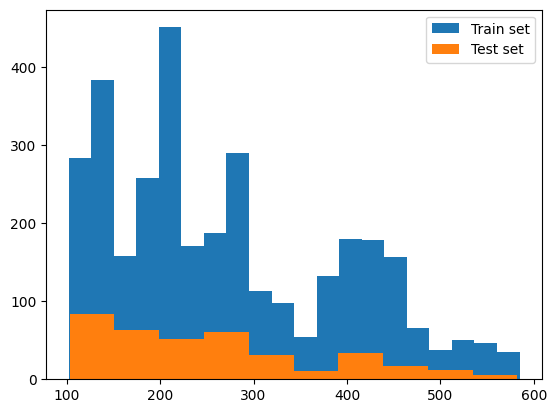

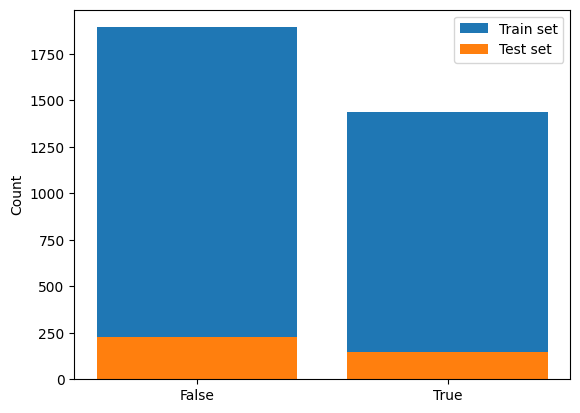

In [20]:
np.random.seed(1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
y_class_train = y_train > y_train.mean()
y_class_test = y_test > y_train.mean()

scaler = StandardScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_normalized = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)
print("y_class_train.shape:", y_class_train.shape)
print("y_class_test.shape:", y_class_test.shape)

plt.hist(y_train, bins=20, label="Train set")
plt.hist(y_test, bins=10, label="Test set")
plt.legend()
plt.show()

plt.bar([0, 1], [len(y_class_train) - y_class_train.sum(), y_class_train.sum()], label="Train set")
plt.bar([0, 1], [len(y_class_test) - y_class_test.sum(), y_class_test.sum()], label="Test set")
plt.xticks([0, 1], ["False", "True"])
plt.ylabel("Count")
plt.legend()
plt.show()

In [21]:
class PredictZero:
    """Model which just predicts y as 0 irrespective of X"""
    def fit(self, X, y):
        pass

    def predict(self, X):
        return np.zeros(len(X))

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

    def get_params(self, deep=True):
        return {}

In [22]:
class PredictOne:
    """Model which just predicts y as 0 irrespective of X"""
    def fit(self, X, y):
        pass

    def predict(self, X):
        return np.ones(len(X))

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

    def get_params(self, deep=True):
        return {}

In [23]:
class PredictPrevious:
    """Model which just predicts y as 0 irrespective of X"""
    def fit(self, X, y):
        pass

    def predict(self, X):
        return X["sp500 close-1"]

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

    def get_params(self, deep=True):
        return {}

In [24]:
class PredictMean:
    """Model which just predicts y as the mean of y in the training set irrespective of X"""
    def fit(self, X, y):
        self.mean_y = np.mean(y)

    def predict(self, X):
        return np.full(len(X), self.mean_y)

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

    def get_params(self, deep=True):
        return {}

In [72]:
%%capture
! pip install ISLP

In [73]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from ISLP.bart import BART
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPRegressor



In [28]:
def evaluate_model(model, X_train, y_train, other_scoring=[], return_estimator=False):
    cv_results = cross_validate(model, X_train, y_train, scoring=["r2", "neg_mean_squared_error"]+other_scoring, cv=10, return_estimator=return_estimator)
    print(f"R2: {print_cv_results(cv_results['test_r2'])}")
    print(f"MSE: {print_cv_results(cv_results['test_neg_mean_squared_error'] * (-1))}")
    for scoring in other_scoring:
        print(f"{scoring}: {print_cv_results(cv_results[f'test_{scoring}'])}")
    print()
    return cv_results

In [29]:
def print_cv_results(results, z=1.96):
    """Prints the mean with confidence intervals (z-score can be modified, default 95% confidence)"""
    mean = np.mean(results)
    std_err = np.std(results) / np.sqrt(len(results))
    return f"{round(mean, 2)} " + u"\u00B1" + f"{round(z * std_err, 2)}"

### Select models to test

In [70]:
run_regression_models = False # @param {type:"boolean"}
run_tree_based_models = True # @param {type:"boolean"}
run_classification_models = False # @param {type:"boolean"}


### Trivial models

In [30]:
print(f"Model: PredictZero")
evaluate_model(PredictZero(), X_train, y_train)

print(f"Model: PredictMean")
evaluate_model(PredictMean(), X_train, y_train)

print(f"Model: PredictPrevious")
evaluate_model(PredictPrevious(), X_train, y_train)
pass

Model: PredictZero
R2: -5.0 ±0.16
MSE: 88382.95 ±2142.51

Model: PredictMean
R2: -0.0 ±0.0
MSE: 14796.37 ±478.48

Model: PredictPrevious
R2: 1.0 ±0.0
MSE: 17.71 ±1.66



### Linear regression/ lasso/ ridge

In [31]:
if run_regression_models:
    print(f"Model: LinearRegression")
    linear_regression = evaluate_model(LinearRegression(), X_train, y_train, return_estimator=True)
    display(pd.DataFrame(zip(X.columns, linear_regression["estimator"][0].coef_.round(3))).sort_values(by=1))

Model: LinearRegression
R2: 1.0 ±0.0
MSE: 10.05 ±1.02



,0,1
10,sp500 open-max-short,-0.342
28,sp500 low-max-long,-0.271
16,sp500 close-max-short,-0.266
0,sp500 open,-0.172
31,sp500 close-min-long,-0.093
11,sp500 open-min-short,-0.065
25,sp500 open-min-long,-0.064
34,sp500 high-low-max-long,-0.062
20,sp500 high-low-max-short,-0.048
17,sp500 close-min-short,-0.046


In [32]:
if run_regression_models:
    print(f"Model: LinearRegression")
    linear_regression = evaluate_model(LinearRegression(), X_train_normalized, y_train, return_estimator=True)
    display(pd.DataFrame(zip(X.columns, linear_regression["estimator"][0].coef_.round(3))).sort_values(by=1))

Model: LinearRegression
R2: 1.0 ±0.0
MSE: 10.05 ±1.02



,0,1
10,sp500 open-max-short,-41.882
28,sp500 low-max-long,-33.360
16,sp500 close-max-short,-32.613
0,sp500 open,-20.922
31,sp500 close-min-long,-10.827
11,sp500 open-min-short,-7.841
25,sp500 open-min-long,-7.434
17,sp500 close-min-short,-5.508
7,sp500 close-2,-4.924
26,sp500 high-max-long,-1.192


In [64]:
if run_regression_models:
    print(f"Model: Ridge")
    alphas = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    best_error = -100
    best_alpha = None
    best_estimator = None
    for alpha in alphas:
        print(f"alpha: {alpha}")
        ridge_results = evaluate_model(Ridge(alpha=alpha), X_train_normalized, y_train, return_estimator=True)
        if ridge_results["test_neg_mean_squared_error"].mean() > best_error:
            best_error = ridge_results["test_neg_mean_squared_error"].mean()
            best_alpha = alpha
            best_estimator = ridge_results["estimator"][0]

    print("best_alpha:", best_alpha)
    print("Best MSE:", -best_error.round(2))
    display(pd.DataFrame(zip(X.columns, best_estimator.coef_.round(3))).sort_values(by=1))


Model: Ridge
alpha: 0.0001
R2: 1.0 ±0.0
MSE: 10.05 ±1.02

alpha: 0.0003
R2: 1.0 ±0.0
MSE: 10.05 ±1.02

alpha: 0.001
R2: 1.0 ±0.0
MSE: 10.04 ±1.02

alpha: 0.003
R2: 1.0 ±0.0
MSE: 10.04 ±1.03

alpha: 0.01
R2: 1.0 ±0.0
MSE: 10.02 ±1.03

alpha: 0.03
R2: 1.0 ±0.0
MSE: 9.99 ±1.04

alpha: 0.1
R2: 1.0 ±0.0
MSE: 9.98 ±1.04

alpha: 0.3
R2: 1.0 ±0.0
MSE: 10.07 ±1.04

alpha: 1
R2: 1.0 ±0.0
MSE: 10.28 ±1.0

alpha: 3
R2: 1.0 ±0.0
MSE: 10.67 ±0.93

alpha: 10
R2: 1.0 ±0.0
MSE: 11.39 ±0.9

best_alpha: 0.1
Best MSE: 9.98


,0,1
10,sp500 open-max-short,-13.708
28,sp500 low-max-long,-12.375
0,sp500 open,-12.057
7,sp500 close-2,-7.547
11,sp500 open-min-short,-6.074
25,sp500 open-min-long,-5.447
31,sp500 close-min-long,-3.016
16,sp500 close-max-short,-1.351
30,sp500 close-max-long,-0.458
34,sp500 high-low-max-long,-0.296


In [65]:
if run_regression_models:
    print(f"Model: Lasso")
    alphas = [0.0005, 0.001, 0.002, 0.003]
    best_error = -100
    best_alpha = None
    best_estimator = None
    for alpha in alphas:
        print(f"alpha: {alpha}")
        lasso_results = evaluate_model(Lasso(alpha=alpha, max_iter=100000), X_train_normalized, y_train, return_estimator=True)
        if lasso_results["test_neg_mean_squared_error"].mean() > best_error:
            best_error = lasso_results["test_neg_mean_squared_error"].mean()
            best_alpha = alpha
            best_estimator = lasso_results["estimator"][0]

    print("best_alpha:", best_alpha)
    print("Best MSE:", -best_error.round(2))
    display(pd.DataFrame(zip(X.columns, best_estimator.coef_.round(3))).sort_values(by=1))


Model: Lasso
alpha: 0.0005
R2: 1.0 ±0.0
MSE: 9.87 ±1.04

alpha: 0.001
R2: 1.0 ±0.0
MSE: 9.87 ±1.03

alpha: 0.002
R2: 1.0 ±0.0
MSE: 9.99 ±1.07

alpha: 0.003
R2: 1.0 ±0.0
MSE: 10.04 ±1.07

best_alpha: 0.001
Best MSE: 9.87


,0,1
0,sp500 open,-12.225
11,sp500 open-min-short,-11.845
10,sp500 open-max-short,-8.719
28,sp500 low-max-long,-1.761
4,sp500 high-low,-0.873
7,sp500 close-2,-0.309
34,sp500 high-low-max-long,-0.232
22,sp500 close diff-max-short,-0.218
19,sp500 volume-min-short,-0.181
20,sp500 high-low-max-short,-0.080


### Tree-based models

In [74]:
# if run_tree_based_models:
#     print(f"Model: BART")
#     evaluate_model(BART(), X_train, y_train)
#     pass

# Model: BART
# R2: 1.0 ±0.0
# MSE: 44.87 ±4.24

Model: BART
R2: 1.0 ±0.0
MSE: 44.87 ±4.24



In [75]:
if run_tree_based_models:
    print(f"Model: RandomForestRegressor")
    # random_forest = RandomForestRegressor()
    # grid_search = GridSearchCV(random_forest, param_grid={'n_estimators': [30, 100, 300]}, cv=3)
    # grid_search.fit(X_train, y_train)
    # best_n_estimators = grid_search.best_params_['n_estimators']
    # print("best_n_estimators:", best_n_estimators)
    # best_n_estimators = 100
    evaluate_model(RandomForestRegressor(n_estimators=100), X_train, y_train)
    pass

# Model: RandomForestRegressor
# R2: 1.0 ±0.0
# MSE: 11.65 ±1.08


Model: RandomForestRegressor
R2: 1.0 ±0.0
MSE: 11.65 ±1.08



In [82]:
if run_tree_based_models:
    print(f"Model: RegressionTree with Pruning")
    # regressor = DecisionTreeRegressor()
    # ccp_path = regressor.cost_complexity_pruning_path(X_train, y_train)
    # ccp_path.alphas = ccp_path.ccp_alphas[::len(ccp_path.ccp_alphas)//4]
    # grid_search = GridSearchCV(regressor, param_grid={'ccp_alpha': ccp_path.ccp_alphas}, cv=3)
    # grid_search.fit(X_train, y_train)
    # best_ccp_alpha = grid_search.best_params_['ccp_alpha']
    # print("best_ccp_alpha:", best_ccp_alpha)
    evaluate_model(DecisionTreeRegressor(ccp_alpha=0.0522087676388758), X_train, y_train)

    pass


Model: RegressionTree with Pruning
R2: 1.0 ±0.0
MSE: 18.29 ±1.66



In [ ]:
# print(f"Model: MLPRegressor")
# evaluate_model(MLPRegressor(max_iter=2000, hidden_layer_sizes=(100,100,100)), X_train, y_train)

### Classification models

In [ ]:
print(f"Model: PredictZero")
evaluate_model(PredictZero(), X_train, y_class_train, other_scoring=["accuracy"])

print(f"Model: PredictOne")
evaluate_model(PredictOne(), X_train, y_class_train, other_scoring=["accuracy"])

print(f"Model: LogisticRegression")
evaluate_model(LogisticRegression(), X_train, y_class_train, other_scoring=["accuracy"])

print(f"Model: LinearDiscriminantAnalysis")
evaluate_model(LogisticRegression(), X_train, y_class_train, other_scoring=["accuracy"])

print(f"Model: QuadraticDiscriminantAnalysis")
evaluate_model(LogisticRegression(), X_train, y_class_train, other_scoring=["accuracy"])


pass